# Ранняя остановка

In [1]:
import numpy as np

## Данные

Возьмём более постой набор данных, чтобы обучение нейронной сети проходило быстрее.
Метод make_moons из sklearn.dataset создаёт набор данных задачи бинароной классификации с границей между классами сложной формы.

Отделим 30 процентов данных на валидационную выборку.

In [2]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.3, random_state=3)

n_train = 30
x_train, x_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

Посмотрим, что на выходе у нас действительно два класса.

In [3]:
print(y_train)
print(y_train.shape)


[1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1]
(30,)


Нарисуем классы.

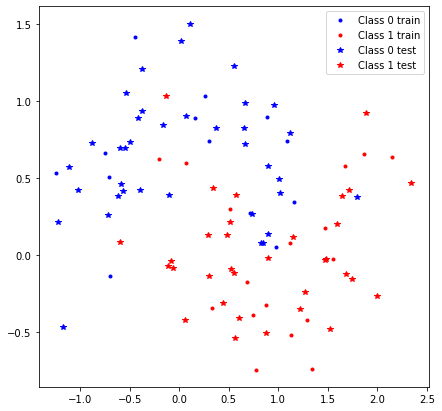

In [4]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(x_train[y_train==0][:,0], x_train[y_train==0][:,1], color='blue', linestyle='None', marker='.', label='Class 0 train')
ax.plot(x_train[y_train==1][:,0], x_train[y_train==1][:,1], color='red', linestyle='None', marker='.', label='Class 1 train')
ax.plot(x_test[y_test==0][:,0], x_test[y_test==0][:,1], color='blue', linestyle='None', marker='*', label='Class 0 test')
ax.plot(x_test[y_test==1][:,0], x_test[y_test==1][:,1], color='red', linestyle='None', marker='*', label='Class 1 test')
ax.legend()
plt.show()

## Нейронная сеть

Создадим нейронную сеть.

На этот раз посмотрим как пользоваться Model API в Keras:
* создаём объект модели, например Sequental - многослойная сеть прямого распространения;
* добавляем в него по очереди наши слои; для первого слоя задаём параметром input_dim размеры входа.
    
На выходе сети используем один сигмоидальный нейрон - так как у нас всего два класса, то нам будет
удобно обучать сеть с единственным выходом, который будет выдавать вероятность принадлежности объекта
классу "1". В этом случае сигмоида хорошо подходит как функция активации для выходного нейрона.

In [5]:
from keras.layers import Dense
from keras.models import Sequential

def make_model():                # нам ещё не один раз потребуется создать модель заново
    model = Sequential()
    model.add(Dense(700, input_dim=2, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = make_model()

Using TensorFlow backend.


Зададим большое количество эпох обучения, чтобы посмотореть, переобучится сеть или нет.

In [6]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2000, verbose=0)

Посмотрим статистики обучения.

In [7]:
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Точность на обучающей выборке: %.3f, точность на тестовой выборке: %.3f' % (train_acc, test_acc))

Точность на обучающей выборке: 1.000, точность на тестовой выборке: 0.886


На обучающей выборке точно классифицируются все объекты, на тестовой - 88.6%. Похоже на переобучение...

Посмотрим на график изменения функции ошибки во время обучения.

In [8]:
def plot_history(history=history):
    fig, ax = plt.subplots(nrows=2, figsize=(15, 8), sharex=True)
    ax[0].plot(history.history['loss'], label='Обучающая выборка')
    ax[0].plot(history.history['val_loss'], label='Тестовая выборка')
    ax[0].set_ylabel('Кроссэнтропия')
    ax[0].legend()
    ax[0].grid(True)
    ax[1].plot(history.history['accuracy'], label='Обучающая выборка')
    ax[1].plot(history.history['val_accuracy'], label='Тестовая выборка')
    ax[1].set_ylabel('Точность')
    ax[1].grid(True)
    plt.show()

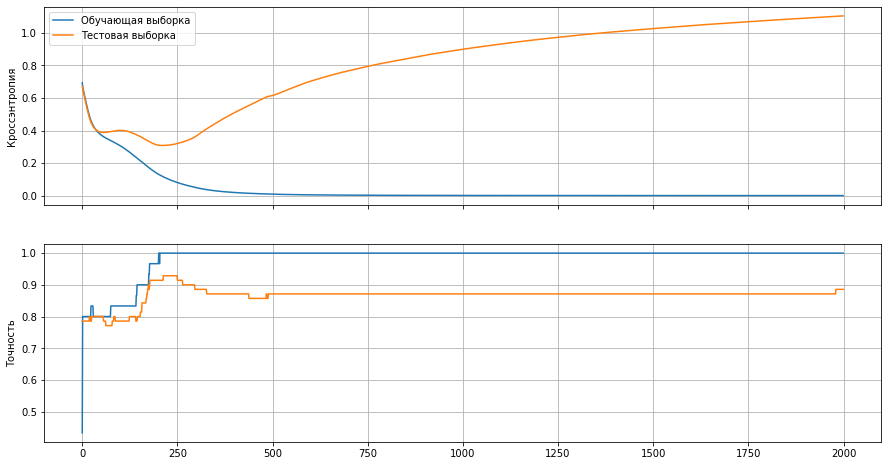

In [9]:
plot_history(history)

Определённо присутствует переобучение - чётко видно, что начиная примерно с эпохи 200 показатели на отложенной выборке начали ухадшатся, в то время как на обучающей выборке они улучшаются.

Обратите внимание, что:
* cтабильный прогресс по всем метрикам наблюдается только в самом начале обучения;
* у кроссэнтропии есть локальный минимум, после которого она повышается, а затем снова снижается перед тем, как начать окончательно расти;
* поведение кроссэнтропии и точности отличаются друг от друга, их экстремумы находятся в разных точках;
* если перезапускать ноутбук с разными random_state при создании данных тут мрожно получать разные графики, в которых переобучение будет начинаться с разных моментов и графики в начале обучения могут иметь разную форму.

Можно посмотреть, как наша модель классифицирует точки плоскости. Для этого посчитаем её выход на точках плотной сетки.

In [10]:
def plot_model(model = model):
    grid_step = 0.02
    x1_min, x1_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    x2_min, x2_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, grid_step),
                           np.arange(x2_min, x2_max, grid_step))
    Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    fig, ax = plt.subplots(figsize=(7,7))
    ax.contourf(xx1, xx2, Z, cmap='bwr', alpha=0.6)
    ax.plot(x_train[y_train==0][:,0], x_train[y_train==0][:,1], color='blue', linestyle='None', marker='.', label='Class 0 train')
    ax.plot(x_train[y_train==1][:,0], x_train[y_train==1][:,1], color='red', linestyle='None', marker='.', label='Class 1 train')
    ax.plot(x_test[y_test==0][:,0], x_test[y_test==0][:,1], color='blue', linestyle='None', marker='*', label='Class 0 test')
    ax.plot(x_test[y_test==1][:,0], x_test[y_test==1][:,1], color='red', linestyle='None', marker='*', label='Class 1 test')
    ax.legend()
    plt.show()

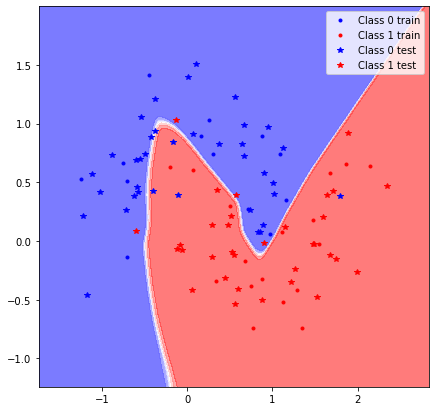

In [11]:
plot_model(model)

##  Ранняя остановка

По графикам обучения видно, что процесс обучения нашей сети имело бы смысл остановить гораздо раньше, чем 2000 заданных эпох.

Это стандартный приём обучения, для которого в Keras есть готовая реализация, использующая механизм callback'ов во время обучения. Чтобы им воспользоваться, нужно:
* создать callback типа keras.callbacks.EarlyStopping задав ему необходимые параметры;
* передать его в аргументе callbacks метода fit, тип аргумента - список callback'ов.

In [12]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', # Ранняя остановка будет реагировать на функцию ошибки на контрольной выброрке
                   mode='min',         # Останавливаться будем когда достигнем минимума
                   verbose=1)          # Будет разговаривать

model = make_model()                   # Делаем модель заново, чтобы начать с необученного состояния сети.

history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                    callbacks = [es],                  # Передаём настроенный callback
                    epochs=2000, verbose=0)

Epoch 00044: early stopping


Обучение остановилось на 45 эпохе. Давайте посмотрим ход обучения.

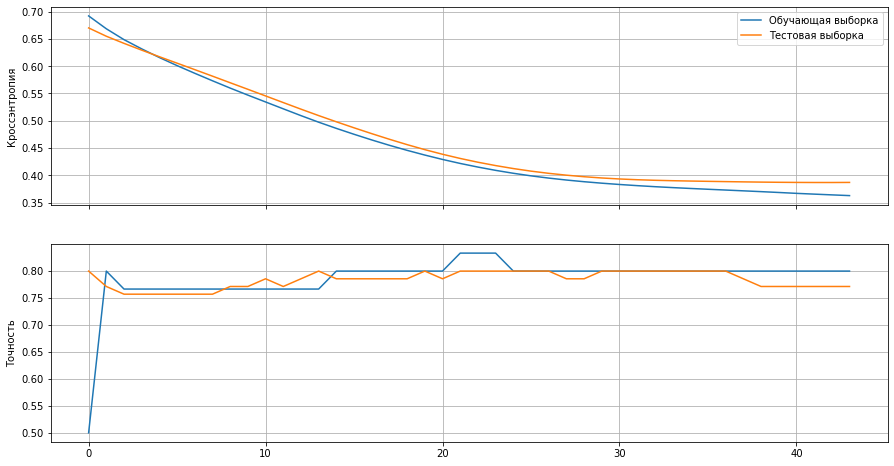

In [13]:
plot_history(history)

Обучение остановлено как только кросс-энтропия на проверочной выборке начала расти. 

Но, мы видели, что первый мимнимум является локальным, и через некоторое время за ним ошибка снова начнёт падать. Чтобы найти следующий, более хороший минимум, нужно переждать период роста ошибки. Для этого у EarlyStopping есть параметр patience, который задаёт число эпох, в течении которых должен наблюдатся рост функции ошибки, чтобы ранняя остановка сработала.

Так как у нас этот рост продолжался достаточно долго, зададим значение побольше.

Epoch 00324: early stopping


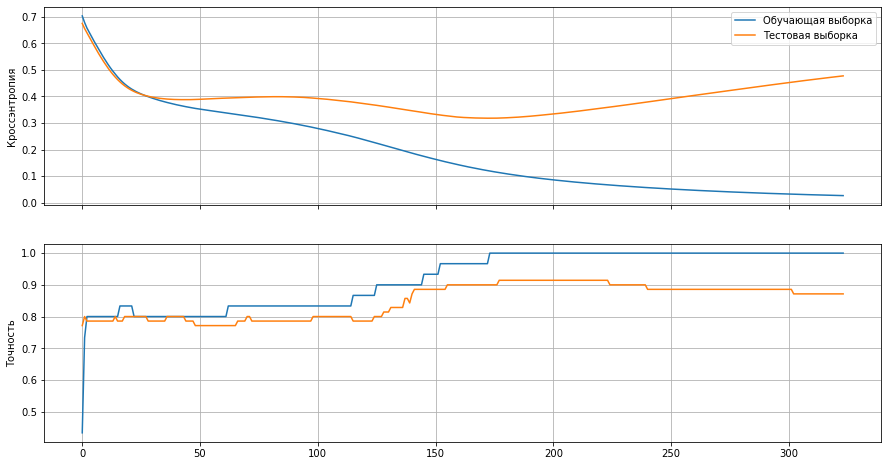

In [14]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience = 150,      # Добавили параметр
                   verbose=1)

model = make_model()

history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                    callbacks = [es],               
                    epochs=2000, verbose=0)

plot_history(history)

Минимумы мы нашли.

Но, теперь другая проблема - так как у нас задан patience = 150, обучение ушло на 150 эпох дальше, чем был последний найденный минимум, и мы имеем на выходе сеть, которая переобучалась лишние 150 эпох. А нам бы желательно получить её в том виде, который соответствует минимуму.

Для этого можно воспользоваться другим callback: ModelCheckpoint, который умеет сохранять модель во время обучения. Ему можно задать параметры, которые заставят его сохранять модель только в том случае, если её показатели превосходят предыдущую. В результате, получим на выходе "самую хорошую" сеть, из всех, что у нас были. (Есть и другие режимы, можно, например, сохранять сеть на всех этапах обучения в разные файлы - смотрите документацию.)

In [15]:
from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('best_model.h5',     # Имя файла, в который будет сохранена сеть. Формат - HDF5
                     monitor='val_loss',  # Будем контроллировать ошибку на проверочной выборке ...
                     mode='min',          # ... и смотреть на её минимум.
                     verbose=1,           # Пусть разговаривает.
                     save_best_only=True) # Сохранять, только если предыдущая модель лучше, согласно monitor и mode

es = EarlyStopping(monitor='val_loss', mode='min', patience = 150, verbose=1)

model = make_model()

history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                    callbacks = [es, mc],               
                    epochs=2000, verbose=0)


Epoch 00001: val_loss improved from inf to 0.67803, saving model to best_model.h5

Epoch 00002: val_loss improved from 0.67803 to 0.66416, saving model to best_model.h5

Epoch 00003: val_loss improved from 0.66416 to 0.65337, saving model to best_model.h5

Epoch 00004: val_loss improved from 0.65337 to 0.64322, saving model to best_model.h5

Epoch 00005: val_loss improved from 0.64322 to 0.63286, saving model to best_model.h5

Epoch 00006: val_loss improved from 0.63286 to 0.62225, saving model to best_model.h5

Epoch 00007: val_loss improved from 0.62225 to 0.61143, saving model to best_model.h5

Epoch 00008: val_loss improved from 0.61143 to 0.60035, saving model to best_model.h5

Epoch 00009: val_loss improved from 0.60035 to 0.58914, saving model to best_model.h5

Epoch 00010: val_loss improved from 0.58914 to 0.57785, saving model to best_model.h5

Epoch 00011: val_loss improved from 0.57785 to 0.56665, saving model to best_model.h5

Epoch 00012: val_loss improved from 0.56665 to

Epoch 00129: val_loss did not improve from 0.38772

Epoch 00130: val_loss improved from 0.38772 to 0.38742, saving model to best_model.h5

Epoch 00131: val_loss improved from 0.38742 to 0.38686, saving model to best_model.h5

Epoch 00132: val_loss improved from 0.38686 to 0.38628, saving model to best_model.h5

Epoch 00133: val_loss improved from 0.38628 to 0.38571, saving model to best_model.h5

Epoch 00134: val_loss improved from 0.38571 to 0.38508, saving model to best_model.h5

Epoch 00135: val_loss improved from 0.38508 to 0.38441, saving model to best_model.h5

Epoch 00136: val_loss improved from 0.38441 to 0.38372, saving model to best_model.h5

Epoch 00137: val_loss improved from 0.38372 to 0.38300, saving model to best_model.h5

Epoch 00138: val_loss improved from 0.38300 to 0.38227, saving model to best_model.h5

Epoch 00139: val_loss improved from 0.38227 to 0.38157, saving model to best_model.h5

Epoch 00140: val_loss improved from 0.38157 to 0.38092, saving model to best_m

Epoch 00225: val_loss did not improve from 0.29991

Epoch 00226: val_loss did not improve from 0.29991

Epoch 00227: val_loss did not improve from 0.29991

Epoch 00228: val_loss did not improve from 0.29991

Epoch 00229: val_loss did not improve from 0.29991

Epoch 00230: val_loss did not improve from 0.29991

Epoch 00231: val_loss did not improve from 0.29991

Epoch 00232: val_loss did not improve from 0.29991

Epoch 00233: val_loss did not improve from 0.29991

Epoch 00234: val_loss did not improve from 0.29991

Epoch 00235: val_loss did not improve from 0.29991

Epoch 00236: val_loss did not improve from 0.29991

Epoch 00237: val_loss did not improve from 0.29991

Epoch 00238: val_loss did not improve from 0.29991

Epoch 00239: val_loss did not improve from 0.29991

Epoch 00240: val_loss did not improve from 0.29991

Epoch 00241: val_loss did not improve from 0.29991

Epoch 00242: val_loss did not improve from 0.29991

Epoch 00243: val_loss did not improve from 0.29991

Epoch 00244:

Вот этот callback действительно разговорчивый. Последняя модель была сохранена на шаге 223.

Посмотрим на графики обучения.

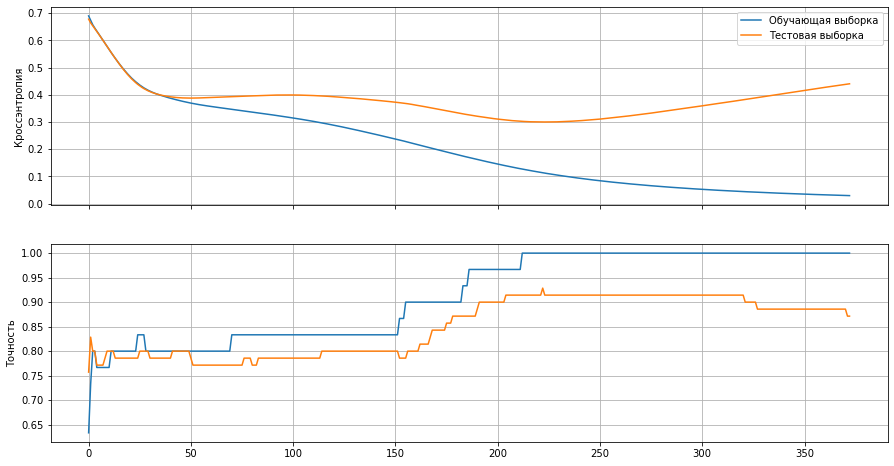

In [16]:
plot_history(history)

Да, 223 выглядит хорошей точкой для остановки обучения, и теперь у нас есть соответствующая сеть, которая сохранена в файле. 


Загрузим её.

In [17]:
from keras.models import load_model

best_model = load_model('best_model.h5')

И протестируем.

In [18]:
print('Последняя модель после обучения:')
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_loss, test_loss))
print('Точность на обучающей выборке: %.3f, точность на тестовой выборке: %.3f' % (train_acc, test_acc))

print('\n"Лучшая" модель:')
train_loss, train_acc = best_model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_loss, test_loss))
print('Точность на обучающей выборке: %.3f, точность на тестовой выборке: %.3f' % (train_acc, test_acc))

Последняя модель после обучения:
Ошибка на обучающей выборке: 0.029, ошибка на тестовой выборке: 0.440
Точность на обучающей выборке: 1.000, точность на тестовой выборке: 0.871

"Лучшая" модель:
Ошибка на обучающей выборке: 0.112, ошибка на тестовой выборке: 0.300
Точность на обучающей выборке: 1.000, точность на тестовой выборке: 0.929


Обратите внимание, что "лучшая" модель имеет худшие показатели на обучающей выборке, но зато лучшие - на контрольной.

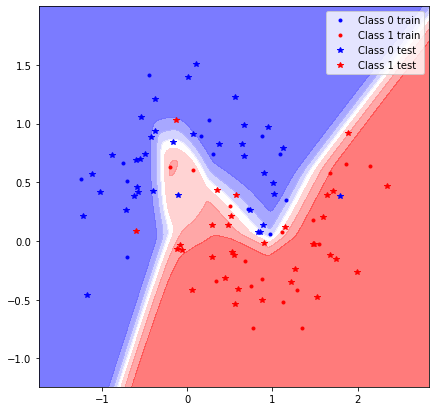

In [19]:
plot_model(best_model)

Можно видеть, что наша "лучшая" модель не столь категорична в своих суждениях и имеет несколько более простую по форме разделяющую классы кривую.

Не забывайте, что коль скоро мы использовали нашу тестовую выборку для определения параметров обучения (в данном случае числа эпох), ошибка на этой выборке уже не отражает ожидаемую ошибку на новых данных: выбрав 223 в качестве нашего числа шагов, мы, тем самым, подогнали сеть под конктерную тестовую выборку, которая у нас есть.

Для того, чтобы проверить эту модель нужно было бы иметь ещё один отложенный набор данных, который не должен был использоваться в ходе обучения, и, скорее всего, мы бы получили на нём другую ошибку. Но, такой набор данных заготовлен не был, и окончательную оценку нашей модели мы не узнаем.

С точки зрения реального применения, при небольшом числе точек как здесь, имело бы смысл использовать более точные методы кросс-валидации (k-fold или даже LOO), это позволило бы нам получать более точные оценки качетсва модели. При этом скорее всего можно выбрать (тоже с помощью кросс-валидации) более простую модель сети (для простой задачи нет смысла использовать сложные сети), что ускорило бы процесс обучения и валидации.

Всё что мы можем сделать в нашем случае - обучить модель на всех данных, используя 223 эпох - с точки зрения полученной в ходе наших экспериментов информации это самое хорошее, что мы можем сделать.

In [24]:
final_model = make_model()

final_model.fit(X, y,       # все данные
                epochs=223, # наше волшебное число эпох
                verbose=0)

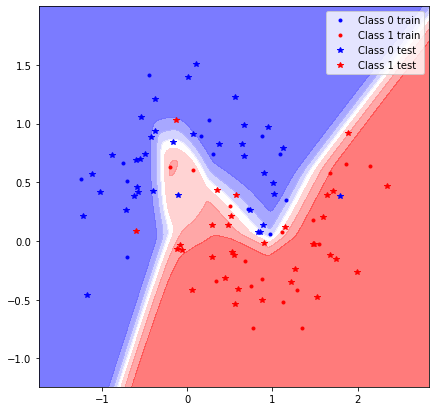

In [25]:
plot_model(best_model)

И теперь, следует воздержаться от соблазна посчитать какие-то ошибки, потому что на самом деле у нас нет данных, на которых можно было бы посчитать ещё какие-то числа, которые у нас не посчитаны, кроме ошибки обучения на всём наборе данных, но она ничего не будет означать.

P.S. Так как простой вариант валидации на отложенной выборке имеет высокую дисперсию, и, кроме того, не зафиксировано состояние
генератора случайных чисел, который используется для инициализации нейронной сети, получаемые результаты могут различаться раз
от раза при перезапуске ноутбука. Итоговое число итераций, в результате, может принимать другие значения, например в первый раз
получилось 188. Жизнь сложна, "лучшие" модели являются лучшими только с точки зрения той методики, которую использовали для их
получения. Используйте k-fold / LOO для более стабильных результатов.